<a href="https://colab.research.google.com/github/ewondare/GNN/blob/main/A_Generalization_of_Transformer_Networks_to_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing the needed libraries

In [ ]:
!pip install -q torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q torch-scatter

In [ ]:
!pip install -q torch-sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q torch-spline-conv

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00


In [ ]:
# PyTorch (already installed in Colab) + PyG and its dependencies all together
# !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import add_self_loops
from torch_scatter import scatter_add, scatter_max
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
import numpy as np

# 2. Loading Data from the Dataset


Dataset used: Cora.
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.
In this Document we will attemp a Node Classification task on the said dataset, using only node features.

In [ ]:
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [ ]:
# add self‐loops so nodes attend to themselves
edge_index, edge_attr = add_self_loops(data.edge_index, # [2,E] Tensor
num_nodes=data.num_nodes)

In [ ]:
# example of projecting node‐features into hidden_dim
in_dim      = dataset.num_node_features
hidden_dim  = 64
input_proj  = nn.Linear(in_dim, hidden_dim)
h0          = input_proj(data.x)    # this is our \hat h_i^0

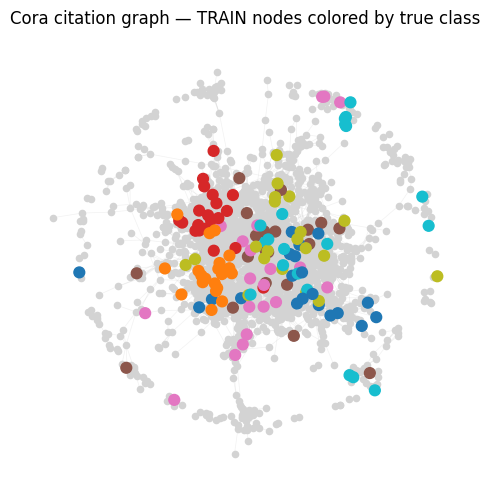

In [ ]:
G   = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)

# Get train vs others=(val+test)
train_idx     = data.train_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()
others_idx    = (~data.train_mask).nonzero(as_tuple=False).view(-1).cpu().numpy()
train_labels  = data.y[train_idx].cpu().numpy()
num_classes   = int(data.y.max().item() + 1)

plt.figure(figsize=(6,6))
#Edges in light gray
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.3, width=0.5)

# draw val+test nodes in faint gray
nx.draw_networkx_nodes(
    G, pos,
    nodelist=others_idx,
    node_size=20,
    node_color='lightgray'
)

# draw train nodes colored by true label
nx.draw_networkx_nodes(
    G, pos,
    nodelist=train_idx,
    node_size=60,
    node_color=train_labels,
    cmap='tab10',
    vmin=0, vmax=num_classes-1
)

plt.title("Cora citation graph — TRAIN nodes colored by true class")
plt.axis('off')
plt.show()


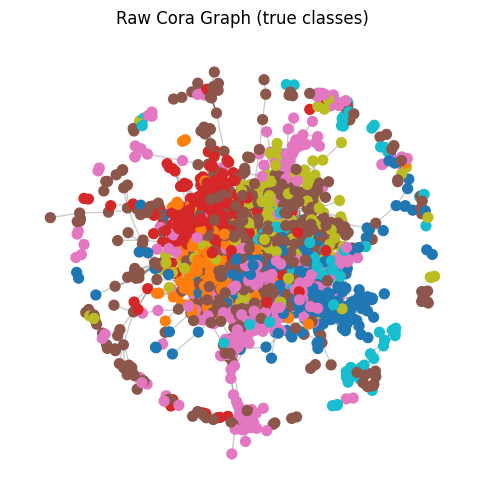

In [ ]:
G = to_networkx(data, to_undirected=True)
labels = data.y.cpu().numpy()
plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos,
                       node_size=50,
                       cmap='tab10',
                       node_color=labels,
                       vmin=0, vmax=dataset.num_classes-1)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Raw Cora Graph (true classes)")
plt.axis('off')
plt.show()


# 3. Input & Edge-feature Embeddings




We first prepare node and edge embeddings for every node $i$ and edge $(i,j)$:

**(1)**  
$$ \hat h_i^0 = A^0\,x_i + a^0, \qquad e_{ij}^0 = B^0\,\beta_{ij} + b^0, $$

where  
- $x_i\in\mathbb R^{d_{\text{in}}}$ is the raw feature of node $i$,  
- $\beta_{ij}\in\mathbb R^{d_e}$ is any edge-feature between $i,j$,  
- $A^0\in\mathbb R^{d_{\text{out}}\times d_{\text{in}}}$, $B^0\in\mathbb R^{d_{\text{out}}\times d_e}$ and biases $a^0,b^0$ are learned via linear layers.

> **Implementation in our notebook:**  
> - Data-prep cell loads `data.x` and (if present) `data.edge_attr`.  
> - In `GraphTransformer.__init__`:  
>   ```python
>   self.input_proj = nn.Linear(in_dim, hidden_dim)
>   # (edge-features would use: self.edge_proj = nn.Linear(edge_dim, hidden_dim))
>   ```

## 3.1. Add Positional Encodings (only at input)

We optionally add Laplacian or random-walk encodings $\lambda_i\in\mathbb R^{d_p}$ to each node:

**(2)**  
$$ h_i^0 = C^0\,\lambda_i + c^0 \;+\; \hat h_i^0, $$

where $C^0\in\mathbb R^{d_{\text{out}}\times d_p}$ and $c^0\in\mathbb R^{d_{\text{out}}}$.

> In our simple demo we did _not_ add positional encodings, but you could do it by:  
> ```python
> pos_proj = nn.Linear(pos_dim, hidden_dim)
> pos_enc  = pos_proj(lambda_i)      # → C^0 λ_i + c^0
> h0       = input_proj(data.x) + pos_enc
> ```


We left out the positional‐encoding step simply because it’s an optional enhancement—not strictly required for the basic Graph Transformer to run. In many standard benchmarks (e.g. node‐classification on Cora) you can get reasonable performance just by projecting the node features and doing attention over the raw graph.

Positional encodings (Laplacian eigenvectors, random‐walk features, etc.) help the model distinguish nodes that have identical features but different structural roles. If your graph is highly regular (or your node features are already very informative), you may not see a big gain from PE. Computing and adding them also incurs extra preprocessing (e.g. eigen-decompositions), so for a minimal demo we omitted PE—but it’s easy to plug in if you find your model struggling to tell structurally “similar” nodes apart.

## 3.2. Multi-Head Graph Attention

Within each `GraphTransformerLayer`, we compute one layer of multi-head attention:

**(4)**  
$$ \hat h_i^{\ell+1} = \big\|_{k=1}^H     \sum_{j\in\mathcal N(i)} \alpha_{ij}^{(k)}\,V_j^{(k)}, \quad \alpha_{ij}^{(k)} = \mathrm{softmax}_j\!\Bigl(\frac{Q_i^{(k)}\!\cdot\!K_j^{(k)}}{\sqrt{d_k}}\Bigr), $$

**(5)**  
$$ Q = XW_Q,\quad K = XW_K,\quad V = XW_V. $$

> **Implementation in** `GraphTransformerLayer.forward`:  
> ```python
> Q = self.to_q(x).view(N, H, d_k)
> K = self.to_k(x).view(N, H, d_k)
> V = self.to_v(x).view(N, H, d_k)
>
> e     = (Q[dst] * K[src]).sum(dim=-1) * self.scale
> e_max = scatter_max(e, dst, dim=0, dim_size=N)[0][dst]
> alpha = (e - e_max).exp()
> alpha = alpha / (scatter_add(alpha, dst, dim=0, dim_size=N)[dst].unsqueeze(-1))
>
> out = scatter_add(alpha.unsqueeze(-1) * V[src], dst, dim=0, dim_size=N)
> out = out.view(N, -1)
> out = self.to_out(out)
> ```


In [ ]:
class GraphTransformerLayer(nn.Module):
    def __init__(self, in_dim, out_dim, heads=4, dropout=0.1):
        super().__init__()
        self.heads    = heads
        self.head_dim = out_dim // heads
        self.scale    = self.head_dim ** -0.5 # for scaled dot‐product

        # Q,K,V projections
        self.to_q   = nn.Linear(in_dim, out_dim, bias=False)
        self.to_k   = nn.Linear(in_dim, out_dim, bias=False)
        self.to_v   = nn.Linear(in_dim, out_dim, bias=False)

        #  Final linear after concatenating heads
        self.to_out = nn.Linear(out_dim, out_dim)

        # Norms and Fead forwad layers
        self.norm1 = nn.LayerNorm(out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(out_dim, 4*out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*out_dim, out_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        N       = x.size(0)
        src, dst = edge_index

        # 1) project to multi-head Q,K,V (with different dimentions to fit multi-head)
        Q = self.to_q(x).view(N, self.heads, self.head_dim)
        K = self.to_k(x).view(N, self.heads, self.head_dim)
        V = self.to_v(x).view(N, self.heads, self.head_dim)

        # 2) compute scaled dot-product
        e     = (Q[dst] * K[src]).sum(dim=-1) * self.scale
        # 2.5) normalize e for less complicated computation
        e_max = scatter_max(e, dst, dim=0, dim_size=N)[0][dst]
        e     = (e - e_max).exp()
        denom = scatter_add(e, dst, dim=0, dim_size=N)[dst]   # [E, H]
        alpha = e / (denom + 1e-16)                           # [E, H]


        # 3) aggregate V with attention weights
        out = scatter_add(alpha.unsqueeze(-1)*V[src], dst, dim=0, dim_size=N)
        out = out.view(N, -1)
        out = self.to_out(out)
        out = self.dropout(out)

        # 4) residual + LayerNorm
        x = self.norm1(x + out)

        # 5) feed-forward + residual + LayerNorm
        ff = self.ffn(x)
        x  = self.norm2(x + ff)
        return x


# 4.Stack Layers & Classify

Finally, we stack $L$ of these layers and attach a classifier:



In [ ]:
class GraphTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim,
                 num_layers=3, heads=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.layers     = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, hidden_dim,
                                  heads=heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x, edge_index)
        return self.classifier(x)

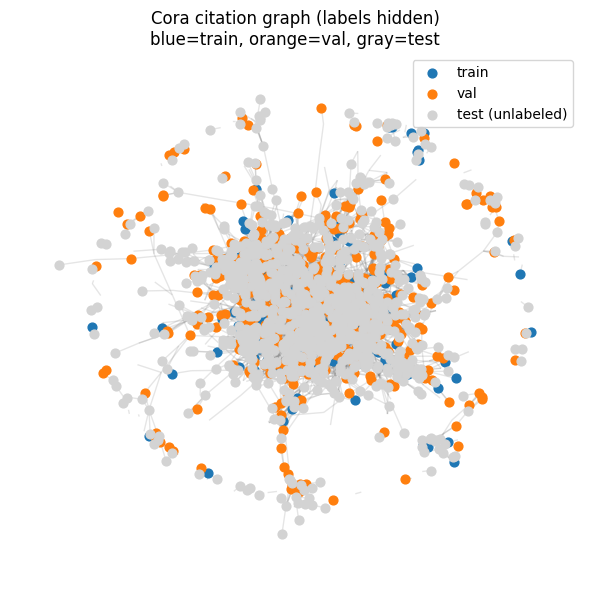

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)   # fixed seed for reproducible layout

# extract node‐index lists for each split
train_idx = data.train_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()
val_idx   = data.val_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()
test_idx  = data.test_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()

plt.figure(figsize=(6,6))
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')

# draw nodes for each mask
nx.draw_networkx_nodes(G, pos,
                       nodelist=train_idx,
                       node_size=40,
                       node_color='tab:blue',
                       label='train')
nx.draw_networkx_nodes(G, pos,
                       nodelist=val_idx,
                       node_size=40,
                       node_color='tab:orange',
                       label='val')
nx.draw_networkx_nodes(G, pos,
                       nodelist=test_idx,
                       node_size=40,
                       node_color='lightgray',
                       label='test (unlabeled)')

plt.title("Cora citation graph (labels hidden)\nblue=train, orange=val, gray=test")
plt.legend(scatterpoints=1, fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = GraphTransformer(dataset.num_node_features, 64,
                             dataset.num_classes).to(device)
data  = data.to(device)
edge_index = edge_index.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
crit = nn.CrossEntropyLoss()

def train():
    model.train()
    opt.zero_grad()
    out = model(data.x, edge_index)
    loss = crit(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()
    return loss.item()



@torch.no_grad()
def test():
    model.eval()
    out  = model(data.x, edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append((pred[mask]==data.y[mask]).float().mean().item())
    return accs

for epoch in range(1, 40):
    loss = train()
    if epoch % 5 == 0:
        train_acc, val_acc, test_acc = test()
        print(f"Epoch {epoch:03d}  Loss {loss:.4f}  "
              f"Train {train_acc:.4f}  Val {val_acc:.4f}  Test {test_acc:.4f}")




Epoch 005  Loss 0.1923  Train 1.0000  Val 0.6540  Test 0.6790
Epoch 010  Loss 0.0463  Train 1.0000  Val 0.6980  Test 0.7100
Epoch 015  Loss 0.0218  Train 1.0000  Val 0.7140  Test 0.7260
Epoch 020  Loss 0.0121  Train 1.0000  Val 0.7100  Test 0.7190
Epoch 025  Loss 0.0075  Train 1.0000  Val 0.7140  Test 0.7160
Epoch 030  Loss 0.0051  Train 1.0000  Val 0.7180  Test 0.7200
Epoch 035  Loss 0.0038  Train 1.0000  Val 0.7080  Test 0.7160


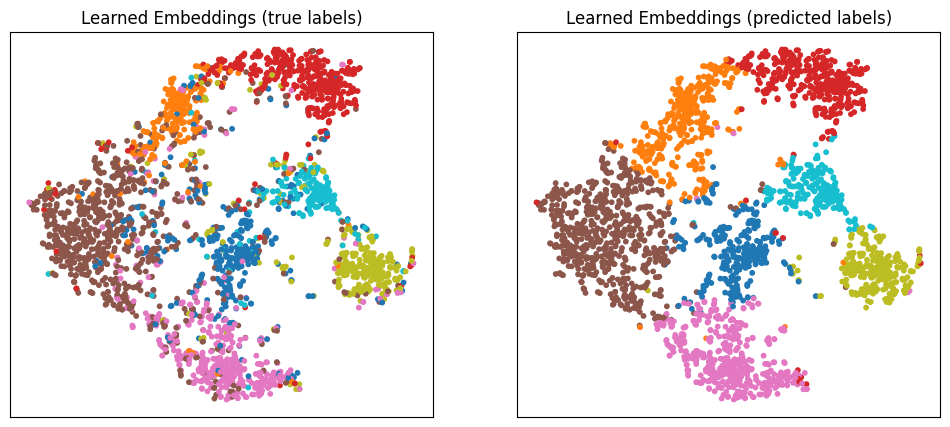

In [ ]:
model.eval()
with torch.no_grad():
    # forward up to before classifier
    x_hid = model.input_proj(data.x)
    for lyr in model.layers:
        x_hid = lyr(x_hid, data.edge_index)
    embeddings = x_hid.cpu().numpy()
    logits     = model.classifier(x_hid).cpu().numpy()
    preds      = logits.argmax(axis=1)

tsne_out = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(tsne_out[:,0], tsne_out[:,1],
                c=labels, cmap='tab10', s=10, vmin=0, vmax=dataset.num_classes-1)
axes[0].set_title("Learned Embeddings (true labels)")
axes[0].set_xticks([]); axes[0].set_yticks([])

axes[1].scatter(tsne_out[:,0], tsne_out[:,1],
                c=preds, cmap='tab10', s=10, vmin=0, vmax=dataset.num_classes-1)
axes[1].set_title("Learned Embeddings (predicted labels)")
axes[1].set_xticks([]); axes[1].set_yticks([])

plt.show()


In [ ]:
def test(model, data, mask_name='test_mask'):
    model.eval()
    # full forward
    logits = model(data.x, data.edge_index)
    # predicted class per node
    pred   = logits.argmax(dim=1)
    # pick the mask (either 'val_mask' or 'test_mask')
    mask   = getattr(data, mask_name)           # <-- this line chooses which split
    # compare preds vs. ground truth only on that split
    correct = (pred[mask] == data.y[mask]).sum().item()
    total   = mask.sum().item()
    return correct / total


In [ ]:
epochs = 40
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # 1) TRAIN accuracy (using train_mask)
    train_acc = int((out.argmax(1)[data.train_mask] == data.y[data.train_mask]).sum()) \
                / int(data.train_mask.sum())

    # 2) VALIDATION accuracy (using val_mask)
    val_acc   = test(model, data, mask_name='val_mask')

    # 3) TEST accuracy (using test_mask)
    test_acc  = test(model, data, mask_name='test_mask')
    if epoch % 5 == 0:
      print(f"Epoch {epoch:02d}  "
            f"Train: {train_acc:.4f}  "
            f"Val:   {val_acc:.4f}  "
            f"Test:  {test_acc:.4f}")


Epoch 05  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 10  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 15  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 20  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 25  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 30  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 35  Train: 1.0000  Val:   0.7220  Test:  0.7410
Epoch 40  Train: 1.0000  Val:   0.7220  Test:  0.7410
